In [1]:
import cv2 as cv
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import pearsonr

from mediapipe import solutions
from google.protobuf.json_format import MessageToJson
import json

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def distance_between(p1_loc, p2_loc, lmk):
    p1 = pd.DataFrame(lmk).to_numpy()[p1_loc]
    p2 = pd.DataFrame(lmk).to_numpy()[p2_loc]
    squared_dist = np.sum((p1-p2)**2, axis=0)
    return(np.sqrt(squared_dist))

def angle_between(base, p1_loc, p2_loc, lmk):
    b = pd.DataFrame(lmk).to_numpy()[base]
    p1 = pd.DataFrame(lmk).to_numpy()[p1_loc]
    p2 = pd.DataFrame(lmk).to_numpy()[p2_loc]
    v1 = p1 - b
    v2 = p2 - b
    angle = np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))
    return((360-((2*np.pi - angle)/np.pi)*180))
    
def landmark_to_dist_emb(result):
    jsonObj = MessageToJson(result.multi_hand_landmarks[0])
    lmk = json.loads(jsonObj)['landmark']
    
    emb = np.array([
    #thumb to finger tip
    distance_between(4,8,lmk),#pointer
    distance_between(4,12,lmk),#middle
    distance_between(4,16,lmk),#ring
    distance_between(4,20,lmk),#pinky
    #distance from each tip to thumb joint
    distance_between(2,8,lmk),#pointer
    distance_between(2,12,lmk),#middle
    distance_between(2,16,lmk),#ring
    distance_between(2,20,lmk),#pinky
    #wrist to finger tip
    distance_between(8,0,lmk),#pointer
    distance_between(12,0,lmk),#middle
    distance_between(16,0,lmk),#ring
    distance_between(20,0,lmk),#pinky
    distance_between(4,0,lmk),#thumb
    #tip to tip (specific to this application)
    #distance_between(8,12,lmk),
    #distance_between(12,16,lmk),
    #within finger joint (detect bending)
    distance_between(8,5,lmk),#pointer
    distance_between(12,9,lmk),#middle
    distance_between(16,13,lmk),#ring
    distance_between(20,17,lmk),#pinky
    distance_between(1,4,lmk)#thumb
    ])
    #use np normalize, as min_max may create confusion that the closest fingers has 0 distance
    emb_norm = emb / np.linalg.norm(emb)
    return(emb_norm)

def landmark_to_angle_emb(result):
    jsonObj = MessageToJson(result.multi_hand_landmarks[0])
    lmk = json.loads(jsonObj)['landmark']
    
    emb = np.array([
    #thumb 
    angle_between(1, 2, 0, lmk),#Thumb roll (CMC)
    angle_between(2, 3, 1, lmk),#MCP (inner joint)
    angle_between(3, 4, 2, lmk),#PIP (IP or outer joint)
    #pointer
    angle_between(5, 6, 0, lmk),#MCP
    angle_between(6, 7, 5, lmk),#PIP    
    angle_between(7, 8, 6, lmk),#DIP
    #middle
    angle_between(9, 10, 0, lmk),#MCP
    angle_between(10, 11, 9, lmk),#PIP
    angle_between(11, 12, 10, lmk),#DIP
    #ring 
    angle_between(13, 14, 0, lmk),#MCP
    angle_between(14, 15, 13, lmk),#PIP 
    angle_between(15, 16, 14, lmk),#DIP
    #pinky
    angle_between(17, 18, 0, lmk),#MCP
    angle_between(18, 19, 17, lmk),#PIP
    angle_between(19, 20, 18, lmk),#DIP
    ])
    return(emb)

In [2]:
results = {}
frames = {}

path = '/Users/kilicb/Desktop/kinematics/'

cap = cv.VideoCapture(path + 'HandClosureMediaPipeDemo.mp4')
frame_no = 0

w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter('HandClosureMediaPipeDemo_output.mp4', fourcc, 20.0, (w,h))


with mp_hands.Hands(max_num_hands = 1, min_detection_confidence = 0.8, min_tracking_confidence = 0.8) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            break
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image.flags.writeable = False
        results[frame_no] = hands.process(image)
# Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        if results[frame_no].multi_hand_landmarks:
            for hand_landmarks in results[frame_no].multi_hand_landmarks:
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        out.write(image)
        cv.imshow('MediaPipe Hands', image)
        
        frame_no += 1
        if cv.waitKey(5) & 0xFF == 27:
            break
    cap.release()
    out.release()
    cv.destroyAllWindows()


I0000 00:00:1709665484.594663       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2 Max
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Ignoring empty camera frame.


In [3]:
bad_frames = []
for i in range(frame_no):
    if results[i].multi_hand_landmarks:
        pass
    else:
        bad_frames.append(i)
good_frames = [i for i in range(frame_no) if i not in bad_frames]

In [4]:
angles = {}

ys = ['Thumb CMC','Thumb MCP','Thumb IP', 
     'Index MCP','Index PIP','Index DIP', 
     'Middle MCP','Middle PIP','Middle DIP', 
     'Ring MCP','Ring PIP','Ring DIP',
     'Pinky MCP','Pinky PIP','Pinky DIP']

fingers = ['D1', 'D2', 'D3', 'D4', 'D5']
colors = ['red', 'blue', 'green']

angles = {ys[j]:[landmark_to_angle_emb(results[i])[j] if i in good_frames else 0 for i in range(frame_no)] for j in range(len(ys))}
df = pd.DataFrame(angles, columns = ys)

In [5]:
# idx = [0,145,345,480, len(df)]
# new_idx = [(5,135),(155,335),(365,465),(490,645)]
angles_split = {}
peaks = {}
temp = {y: df[y] for y in ys}
angles_split = pd.DataFrame(temp, columns = ys)
# for j, y in enumerate(ys):
#     peaks['%d,%d'%(i,j)] = find_peaks(angles_split['%d'%i][y], distance = 10)[0]

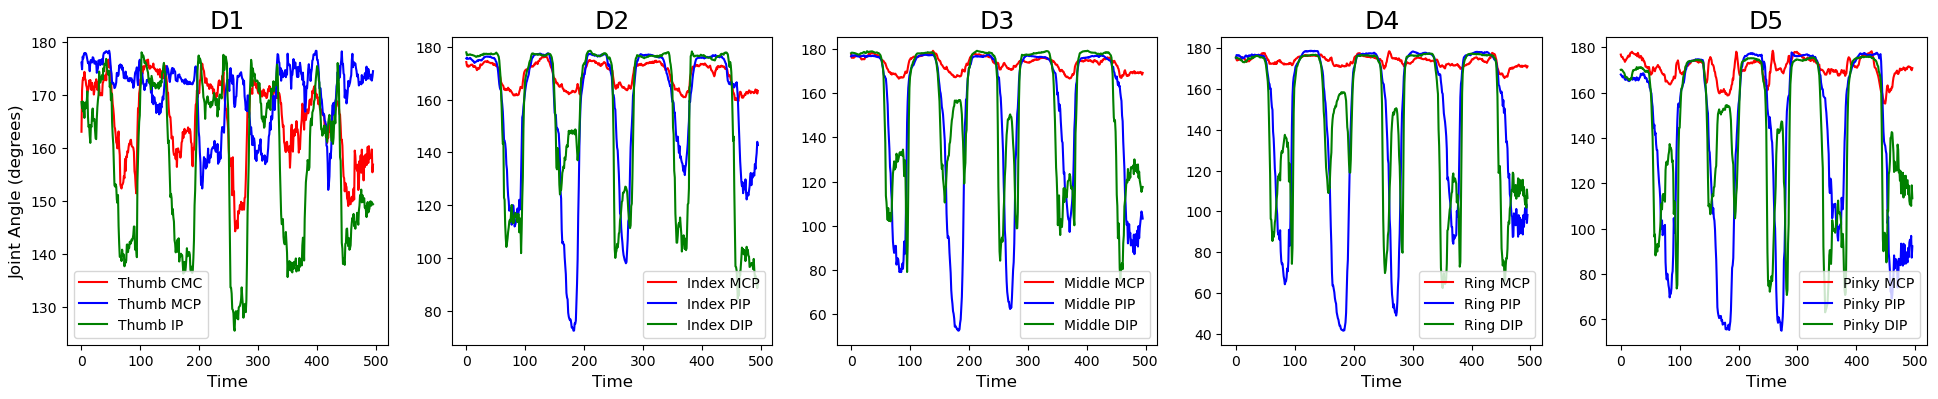

In [6]:
fig, ax = plt.subplots(1,5,figsize = (24,4))
for j, y in enumerate(ys):
    ax[int(j/3)].plot(np.arange(frame_no), angles_split[y], label = '%s'%ys[j], c = colors[int(j%3)])
    #ax[int(j/3)].scatter(new_idx[i][0]+peaks['%d,%d'%(i,j)], angles_split['%d'%i][y].iloc[list(peaks['%d,%d'%(i,j)])], marker = 'x', c = colors[int(j%3)])
    ax[int(j/3)].legend()
    #ax[int(j/3)].set_ylim(0.5,3.2)
    #ax[i][int(j/3)].set_xticks(ticks = list(np.arange(new_idx[i][0],new_idx[i][1],40)))
    ax[int(j/3)].set_title('%s'%fingers[int(j/3)], fontsize = 18)
    ax[int(j/3)].set_xlabel('Time', fontsize = 12)
    ax[0].set_ylabel('Joint Angle (degrees)', fontsize = 12)
        #for x in peaks['%d,%d'%(i,j)]:
            #ax[i][int(j/3)].axvline(new_idx[i][0]+x,0,1, c = colors[int(j%3)], ls = 'dotted', alpha = 0.5)
# plt.tight_layout()
plt.savefig('/Users/kilicb/Desktop/kinematics/HandClosureMediaPipeDemo_time_series.pdf')

In [35]:
interpolated_angles = {}
intervals = {}
avg_angles = {}
std_angles = {}
resampling_int = 1001
for i, mode in enumerate(modes):
    for j, y in enumerate(ys):        
        intervals['%d,%s'%(i,y)] = [(x,x+np.argmin(angles_split['%d'%i][y][peaks['%d,%d'%(i,j)][k]:peaks['%d,%d'%(i,j)][k+1]])) for k, x in enumerate(peaks['%d,%d'%(i,j)][:-1])]
        A = np.zeros((resampling_int,len(intervals['%d,%s'%(i,y)])))
        for p in range(len(intervals['%d,%s'%(i,y)])):
            A[:,p] = np.interp(np.linspace(0, 1, resampling_int), np.linspace(0, 1, len(angles_split['%d'%i][y][intervals['%d,%s'%(i,y)][p][0]:intervals['%d,%s'%(i,y)][p][1]])), angles_split['%d'%i][y][intervals['%d,%s'%(i,y)][p][0]:intervals['%d,%s'%(i,y)][p][1]])
        interpolated_angles['%d,%s'%(i,y)] = A
        avg_angles['%d,%s'%(i,y)] = A.mean(axis = 1)
        std_angles['%d,%s'%(i,y)] = A.std(axis = 1)

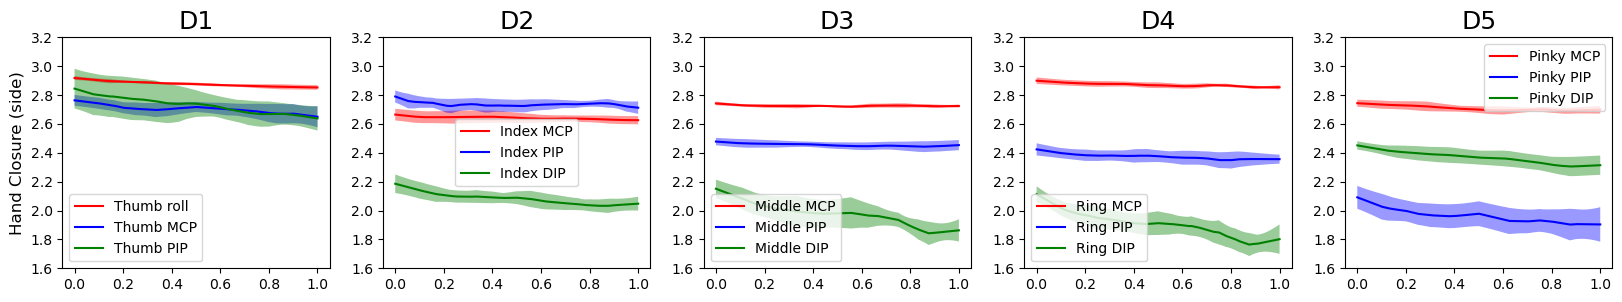

In [36]:
fig, ax = plt.subplots(1,5,figsize = (20,3))
for i, mode in enumerate(modes[:1]):
    for j, y in enumerate(ys):
        ax[int(j/3)].plot(np.linspace(0, 1, resampling_int), avg_angles['%d,%s'%(i,y)], label = '%s'%ys[j], c = colors[int(j%3)])
        ax[int(j/3)].fill_between(np.linspace(0, 1, resampling_int), avg_angles['%d,%s'%(i,y)]+std_angles['%d,%s'%(i,y)], avg_angles['%d,%s'%(i,y)]-std_angles['%d,%s'%(i,y)], facecolor = colors[int(j%3)], alpha = 0.4)
        ax[int(j/3)].legend()
        ax[int(j/3)].set_ylim(1.6,3.2)
        ax[0].set_ylabel('%s'%mode, fontsize = 12)
        ax[int(j/3)].set_title('%s'%fingers[int(j/3)], fontsize = 18)
        
plt.savefig('/Users/kilicb/Desktop/kinematics/figs/masiero_plots.svg')

## Experiments 2016

In [37]:
path = '/Users/kilicb/Desktop/kinematics/exps_2016/'
file_names = ['PAR_2_first_Day_passive', 'PAR_2_last_Day_passive', 'PAR_4_first_Day_passive', 'PAR_4_last_Day_passive']
file_alias = ['P2_FD', 'P2_LD', 'P5_FD', 'P5_LD']

column_names = ['index', 'TIME', 
                'Thumb roll','Thumb MCP','Thumb PIP','Thumb-Index AA', 
                'Index MCP','Index PIP','Index DIP',
                'No label given',
                'Middle MCP','Middle PIP','Middle DIP','Index-Middle AA',
                'Ring MCP','Ring PIP','Ring DIP','Middle-Ring AA',
                'Pinky MCP','Pinky PIP','Pinky DIP','Ring-Pinky AA',
                'Palm flex','Wrist pitch','Wrist yaw', 
                'none1', 'none2', 'none3','none4', 'none5']
drop_labels = ['index', 'none1', 'none2', 'none3', 'none4', 'none5', 
               'Thumb-Index AA','Middle-Ring AA', 'Ring-Pinky AA','Index-Middle AA',
               'Palm flex','Wrist pitch','Wrist yaw', 
               'No label given']

xs = ['TIME']
ys = ['Thumb roll','Thumb MCP','Thumb PIP', 
     'Index MCP','Index PIP','Index DIP', 
     'Middle MCP','Middle PIP','Middle DIP', 
     'Ring MCP','Ring PIP','Ring DIP',
     'Pinky MCP','Pinky PIP','Pinky DIP']

# ys_temp = ['Thumb MCP','Thumb PIP', 'Thumb roll', 
#      'Index MCP','Index PIP','Index DIP (no sensor)', 
#      'Middle MCP','Middle PIP','Middle DIP (no sensor)', 
#      'Ring MCP','Ring PIP','Ring DIP (no sensor)',
#      'Pinky MCP','Pinky PIP','Pinky DIP (no sensor)']

titles = ['MCP','PIP','DIP']
fingers = ['D1', 'D2', 'D3', 'D4', 'D5']

In [38]:
interpolated_files = {}
ps = np.arange(1,31)
resampling_int = 1001
for i, name in enumerate(file_names):
    for p in ps:
        temp = pd.read_csv(path + '%s/p%d.csv'%(name,p), names = column_names, index_col = False)
        temp.drop(columns = drop_labels, inplace = True)
        temp_dict = {y:np.interp(np.linspace(0, 1, resampling_int), np.linspace(0, 1, len(temp[temp.TIME<10][y])), temp[temp.TIME<10][y]) for y in ys}
        interpolated_files['%d,%d'%(i,p)] = pd.DataFrame(temp_dict, columns = ys)
        #interpolated_files['%d,%d'%(i,p)] = interpolated_files['%d,%d'%(i,p)][ys]#reorder columns

In [39]:
avg_files = {}
std_files = {}

for i, name in enumerate(file_names):
    avg_temp = {}
    std_temp = {}
    for j, y in enumerate(ys):
        A = np.zeros((resampling_int, len(ps)))
        for k, p in enumerate(ps):
            A[:,k] = interpolated_files['%d,%d'%(i,p)][y]
        avg_temp[y] = A.mean(axis = 1)
        std_temp[y] = A.std(axis = 1)
    avg_files['%d_avg'%i] = pd.DataFrame(avg_temp, columns = ys)
    std_files['%d_std'%i] = pd.DataFrame(std_temp, columns = ys)

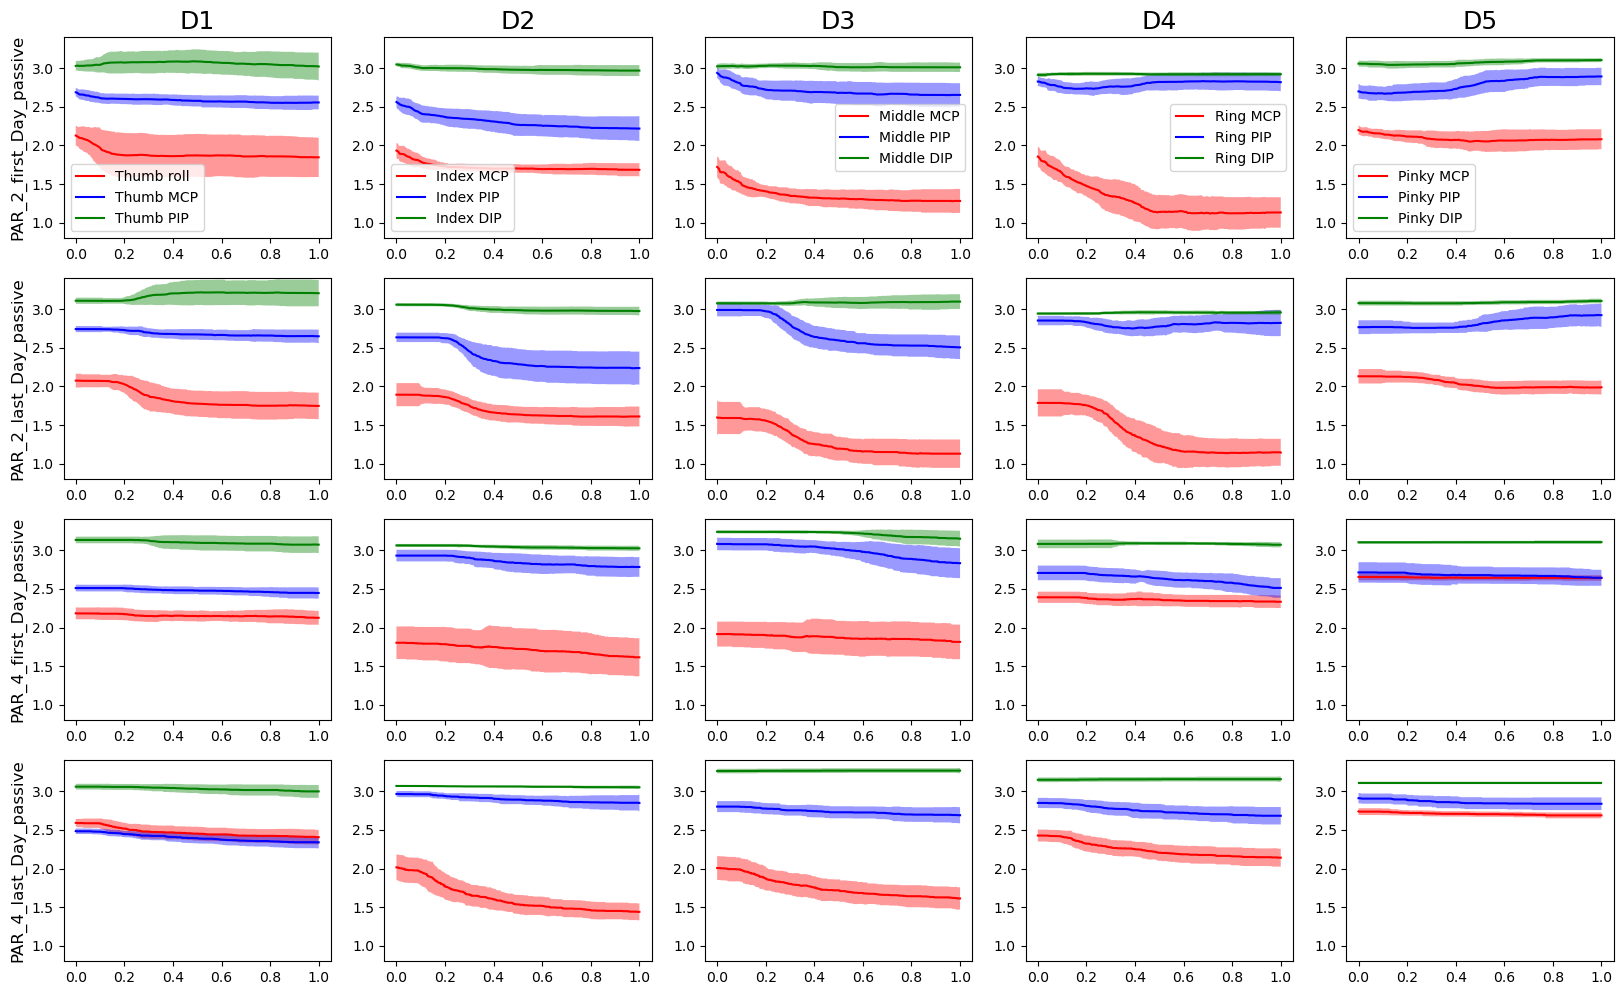

In [40]:
fig, ax = plt.subplots(4,5,figsize = (20,12))
for i, name in enumerate(file_names):
    for j, y in enumerate(ys):
        ax[i][int(j/3)].plot(np.linspace(0, 1, resampling_int), avg_files['%d_avg'%i][y]+np.pi, label = '%s'%ys[j], c = colors[int(j%3)])
        ax[i][int(j/3)].fill_between(np.linspace(0, 1, resampling_int), avg_files['%d_avg'%i][y]+std_files['%d_std'%i][y]+np.pi, avg_files['%d_avg'%i][y]-std_files['%d_std'%i][y]+np.pi, facecolor = colors[int(j%3)], alpha = 0.4)
        ax[0][int(j/3)].legend()
        ax[i][int(j/3)].set_ylim(0.8,3.4)
        ax[i][0].set_ylabel('%s'%name, fontsize = 12)
        ax[0][int(j/3)].set_title('%s'%fingers[int(j/3)], fontsize = 18)
        
plt.savefig('/Users/kilicb/Desktop/kinematics/figs/cyberglove_plots.svg')

## Correlations

In [41]:
corr_all = np.zeros((len(ys)*len(modes[:1]),len(ys)*len(file_names)))

for i, mode in enumerate(modes[:1]):
    for k, name in enumerate(file_names):
        for j, y in enumerate(ys):
            corr_all[j*i,j*k] = pearsonr(np.diff(avg_angles['%d,%s'%(i,y)]),np.diff(avg_files['%d_avg'%k][y].to_numpy()+np.pi))[0]

yticks = []          
for i, mode in enumerate(modes[:1]):
    for j, y in enumerate(ys):
        yticks.append('%s %s'%(mode_alias[i], y))
xticks = []  
for k, name in enumerate(file_names):
    for j, y in enumerate(ys):
        xticks.append('%s %s'%(file_alias[k], y))

/Users/kilicb/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [42]:
# fig,ax = plt.subplots(1,1,figsize = (15,6))
# im = ax.imshow(corr_all, cmap = 'seismic', interpolation = 'none', aspect = 'auto')
# ax.set_yticks(ticks = np.arange(len(ys)*len(modes[:2])), labels =  yticks)
# ax.set_xticks(ticks = np.arange(len(ys)*len(file_names)), labels =  xticks)
# ax.set_xticklabels(xticks, rotation=90)
# ax.set_title('Correlation between all epochs and digit angles', fontsize = 20)
# fig.colorbar(im)

In [43]:
corr_within = {}
p_vals_within = {}

for j, y in enumerate(ys):
    corr = np.zeros((len(modes[:1]),len(file_names)))
    p_vals = np.zeros((len(modes[:1]),len(file_names)))
    for i, mode in enumerate(modes[:1]):
        for k, name in enumerate(file_names):
            corr[i,k], p_vals[i,k] = pearsonr(np.diff(avg_angles['%d,%s'%(i,y)]),np.diff(avg_files['%d_avg'%k][y].to_numpy()+np.pi))
    corr_within[y] = corr
    p_vals_within[y] = p_vals

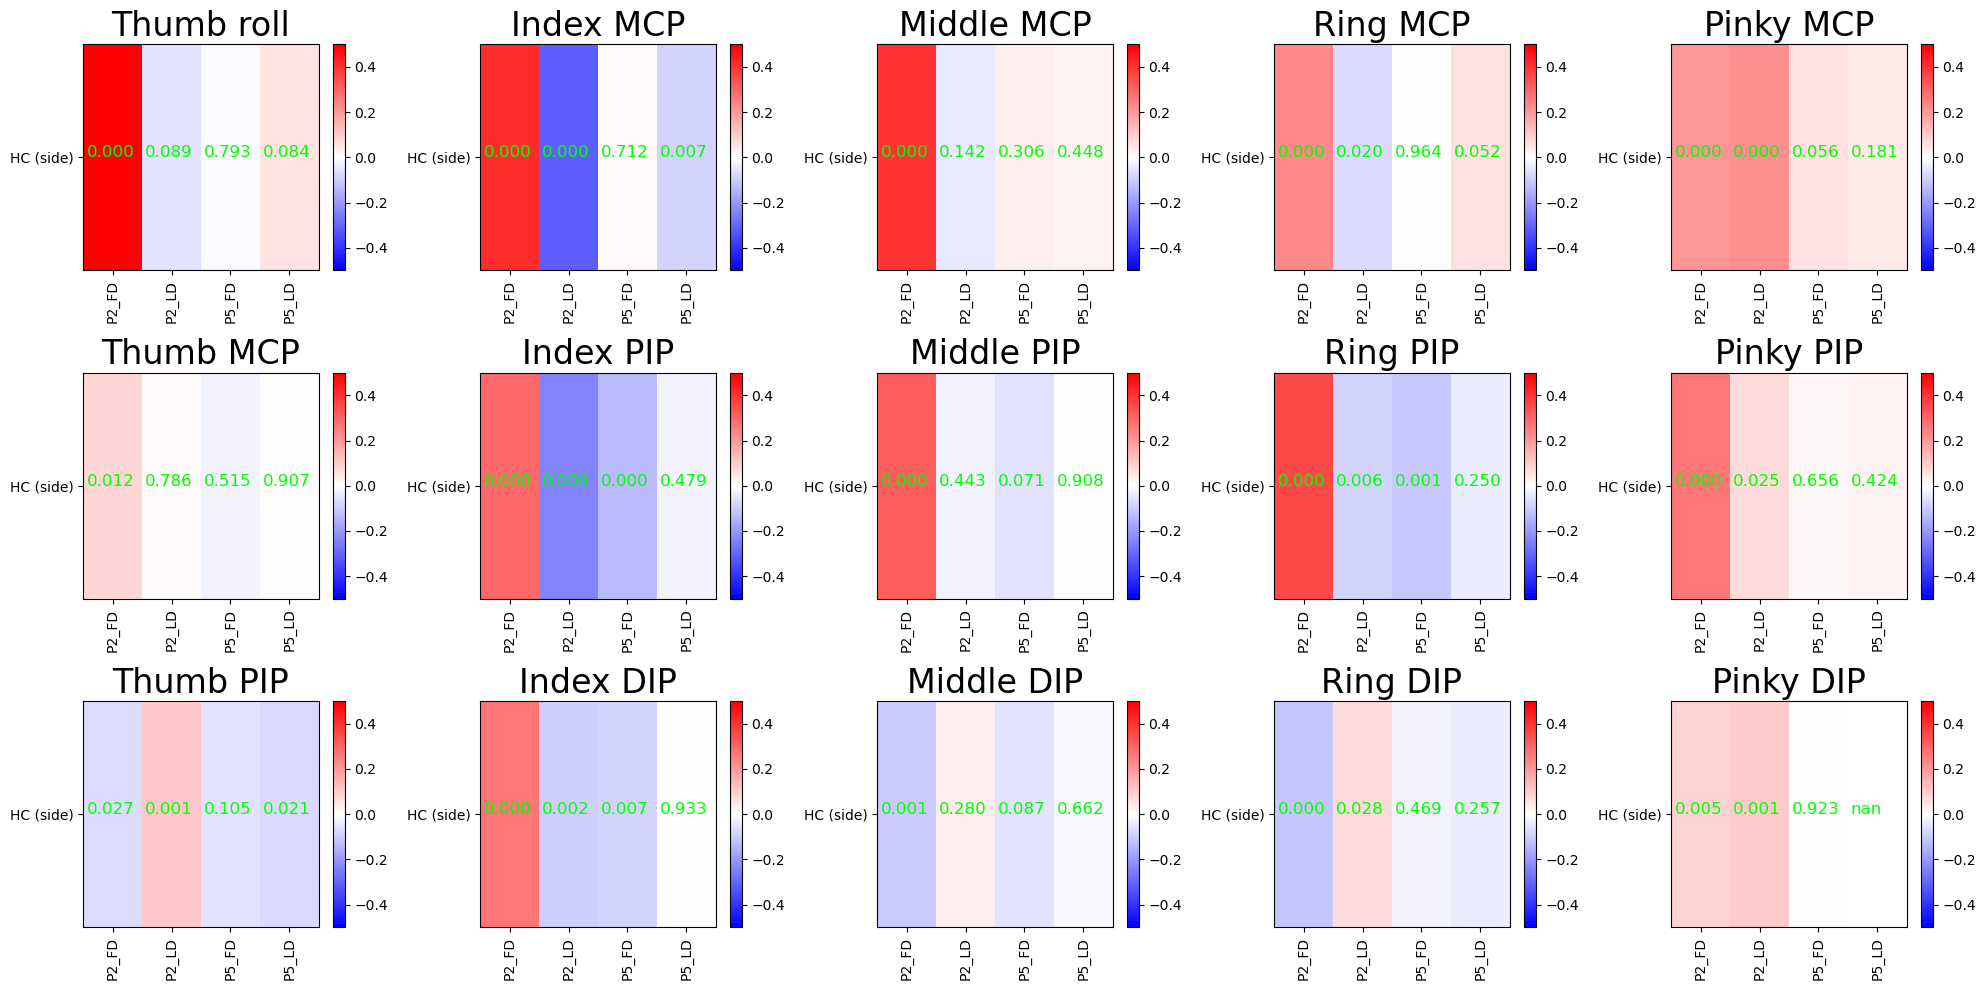

In [44]:
fig,ax = plt.subplots(3,5,figsize = (20,10))
for j, y in enumerate(ys):
    im = ax[int(j%3)][int(j/3)].imshow(corr_within[y], vmin = -0.5, vmax = 0.5, cmap = 'bwr', interpolation = 'none', aspect = 'auto')
    for i, mode in enumerate(modes[:1]):
        for k, name in enumerate(file_names):
            ax[int(j%3)][int(j/3)].text(k-0.45,i,'%.3f'%p_vals_within[y][i,k], fontsize = 12, c = 'lime')
    ax[int(j/5)][int(j%5)].set_yticks(ticks = np.arange(len(modes[:1])), labels =  mode_alias[:1])
    ax[int(j/5)][int(j%5)].set_xticks(ticks = np.arange(len(file_names)), labels =  file_alias, fontsize = 10)
    ax[int(j/5)][int(j%5)].set_xticklabels(file_alias, rotation = 90)
    ax[int(j%3)][int(j/3)].set_title('%s'%y, fontsize = 24)
    fig.colorbar(im)
plt.tight_layout()
plt.savefig('/Users/kilicb/Desktop/kinematics/figs/cyberglove_masiero_correlations.svg')